## Simulation

In [1]:
from tadawol.history import get_top_tickers
from tadawol.strategies import recovery
from tadawol.strategies import macd
from tadawol.strategies import earnings

top_tickers = get_top_tickers(0, 500)
strategy = macd.MACD()
data = strategy.simulate(top_tickers)
print("Entries number = ", data.shape)

2020-10-12 22:22:20,478 tadawol.history INFO     Historical data is extracted, rows_umber = 1001766
2020-10-12 22:22:20,578 tadawol.strategies.base_strategy INFO     Simulating strategy for 495 tickers
2020-10-12 22:22:34,665 tadawol.strategies.base_strategy INFO     Simulation in progress : 4%
2020-10-12 22:22:48,705 tadawol.strategies.base_strategy INFO     Simulation in progress : 8%
2020-10-12 22:23:02,639 tadawol.strategies.base_strategy INFO     Simulation in progress : 12%
2020-10-12 22:23:17,044 tadawol.strategies.base_strategy INFO     Simulation in progress : 16%
2020-10-12 22:23:30,229 tadawol.strategies.base_strategy INFO     Simulation in progress : 20%
2020-10-12 22:23:43,661 tadawol.strategies.base_strategy INFO     Simulation in progress : 24%
2020-10-12 22:23:56,642 tadawol.strategies.base_strategy INFO     Simulation in progress : 28%
2020-10-12 22:24:09,649 tadawol.strategies.base_strategy INFO     Simulation in progress : 32%
2020-10-12 22:24:24,489 tadawol.strategi

Entries number =  (40884, 88)


## Add companies general data

In [2]:
# JOIN RESULTS WITH TICKERS DATA
import pandas as pd
from math import log


from tadawol import history

tickers_data = pd.read_csv(history.TICKERS_LIST_PATH)

data = pd.merge(tickers_data, data, on="Ticker", how="inner")
data.rename(columns={"Volume_y": "Volume"}, inplace=True)


## Get earnings

In [3]:
from tadawol.earnings import get_earnings_data_on_all_dates

earnings_by_date = get_earnings_data_on_all_dates(data)
data_with_earnings = pd.merge(data, earnings_by_date, on=["Ticker", "Date"])

print("SHAPES RATIO = ", round(data_with_earnings.shape[0]/data.shape[0], 2))


2020-10-12 22:30:58,614 tadawol.earnings INFO     Tickers number = 473
2020-10-12 22:31:20,754 tadawol.earnings INFO     [Earnings] Treated tickers number = 21%
2020-10-12 22:31:42,331 tadawol.earnings INFO     [Earnings] Treated tickers number = 42%
2020-10-12 22:32:07,795 tadawol.earnings INFO     [Earnings] Treated tickers number = 63%
2020-10-12 22:32:30,416 tadawol.earnings INFO     [Earnings] Treated tickers number = 85%
2020-10-12 22:32:44,451 tadawol.earnings INFO     Putting data into dataframe ...: rows number = 40681
2020-10-12 22:32:44,497 tadawol.earnings INFO     Adding features ...


SHAPES RATIO =  1.0


## Helper functions

In [4]:
from math import log

def get_volume_category(volume):
    if log(volume) <= 14:
        return "Low Volume"
    if log(volume) <= 16:
        return "Medium Volume"
    return "High Volume"

data_with_earnings["Volume_category"] = data_with_earnings.Volume.map(get_volume_category)


In [5]:
def print_results_data(df):
    print("days_since_last_result : ", df["days_since_last_result"].mean())
    print("days_to_next_result : ", df["days_to_next_result"].mean())
    print("average earnings surprise: ", df["earnings_surprise"].mean())
    
def print_results_by_column(df):
    
    bad_results = df[df["win_percent"] < -3]
    good_results = df[df["win_percent"] > 3]
    
    columns = ["days_since_last_result", "days_to_next_result", "earnings_surprise", "exit_date", "week_previous_entries"]
    
    for column in columns:
        print(f"***** {column} *****")
        print("Bad result : ", round(bad_results[column].mean(), 2))
        print("Good result : ", round(good_results[column].mean(), 2))


In [6]:
import pandas as pd
import statistics 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prettytable import PrettyTable

def _performance_by(df, column, index):
    
    x = []
    labels = []
    occurences = []
    win_percents = []
    i = 1
    for column_value, column_data in df.groupby([column]):
        labels.append(column_value)
        x.append(i)
        occurences.append(column_data.shape[0])
        win_percent = column_data["win_percent"].mean()
        win_percents.append(win_percent)
        i += 1
    
    f = plt.figure(index)
    plt.plot(x, occurences)
    plt.plot(x, len(x)* [statistics.mean(occurences)])
    plt.xticks(x, labels, rotation='vertical')
    f.show()
    
    index += 1
    g = plt.figure(index)
    plt.plot(x, win_percents)
    plt.plot(x, len(x)* [0])
    plt.xticks(x, labels, rotation='vertical')
    g.show()


def simulate_trades(df, total_amount: int, min_invest_per_trade: float, max_trades_by_day):
    
    transaction_min = min_invest_per_trade * total_amount
    transaction_max = 2 * transaction_min
    current_amount = total_amount
    df = df.sort_values(by="Date", ascending=True)
    date = df["Date"].min()
    
    returned_money_by_date = dict()
    trade_fees = 0
    realized_trades = []
    while date < datetime.now():
        #recuperate money
        money_to_recupere = returned_money_by_date.get(date, 0)
        current_amount += money_to_recupere
        returned_money_by_date[date] = 0
        
        # see available money
        day_trades = df[df["Date"] == date]
        
        #print(returned_money_by_date)
        day_trades_number = min(day_trades.shape[0], max_trades_by_day)
        if day_trades_number == 0 or current_amount/day_trades_number < transaction_min:
            date += timedelta(days=1)
            continue
        
        money_by_trade = current_amount/day_trades_number
        money_by_trade = min(money_by_trade, transaction_max)
        
        
        # SORT BY EARNINGS
        day_trades.sort_values(by="earnings_surprise", ascending=False, inplace=True)
        
        trade_number = 0
        for _, trade_row in day_trades.iterrows():
            trade_number += 1
            
            current_amount -= money_by_trade
            trade_fees += 2
            # add money to exit
            
            money_to_be_returned = (1 + trade_row["win_percent"]/100.0) * money_by_trade
            
            exit_date =date + timedelta(days=trade_row["exit_date"])
            returned_money_on_exit = returned_money_by_date.get(exit_date, 0)
            returned_money_by_date[exit_date] = returned_money_on_exit + money_to_be_returned
            
            realized_trades.append(
                [
                    trade_row["Ticker"], 
                    date, 
                    trade_row["exit_date"],
                    trade_row["Close"], 
                    trade_row["exit_price"], 
                    trade_row["win_percent"]
                ]
            )
            
            if trade_number == day_trades_number:
                break
        
        date += timedelta(days=1)
        
    rest_money = 0
    for m in returned_money_by_date.values():
        rest_money += m
    
    
    win = rest_money + current_amount - total_amount
    realized_trades_df = pd.DataFrame(
        data=realized_trades, 
        columns=["Ticker", "Date", "Exit date", "Enter price", "Exit price", "win_percent"])
    return win, trade_fees, realized_trades_df

def plot_trades(trades_df, plot_index):
    
    months = []
    win_percents = []
    
    trades_df["month"] = trades_df["Date"].map(lambda x: datetime(x.year, x.month, 1))
    
    for month, month_trades in trades_df.groupby(["month"]):
        trades_product = 1
        months.append(month)
        win_percents.append( month_trades["win_percent"].mean())
        
    f = plt.figure(plot_index)
    x = range(1, len(months) + 1)
    plt.plot(x, win_percents)
    plt.plot(x, len(win_percents) * [0])
    plt.xticks(x, months, rotation='vertical')
    f.show()
    
def analyse_results(df: pd.DataFrame, print_figures: bool = True, total_amount=20000, min_invest_per_trade=0.02, max_trades_by_day=4) -> None:
    assert 0 < min_invest_per_trade <= 0.1
    df = df.copy(deep=True)
    min_date = df["Date"].min()
    max_date = df["Date"].max()
    days_number = (5.0 / 7.0) * (max_date - min_date).total_seconds() / (60 * 60 * 24) + 1
    win, trade_fees, realized_trades_df = simulate_trades(df, total_amount, min_invest_per_trade, max_trades_by_day)
    
    
    x = PrettyTable()
    x.field_names = ["KPI", "value"]

    x.add_row(["Enter cases number", df.shape[0]])
    x.add_row(["Cases number per day", round(df.shape[0]/days_number, 2)])
    x.add_row(["Average winning cases", round(100 * df[df["win_percent"] >= 0].shape[0] / df.shape[0], 1)])
    x.add_row(["Average win", round(df["win_percent"].mean(), 2)])
    x.add_row([f"Win for {round(total_amount/1000)} K€", round(win)])
    x.add_row(["Trade fees", trade_fees])
    x.add_row(["Trade number", realized_trades_df.shape[0]])
    x.add_row(["Total margin", round(100 * (win - trade_fees)/total_amount, 1)])
    print(x)
    df.loc[:, "win_percent"] = df["win_percent"].astype(float)
    df[["win_percent"]].hist(bins=50)
    
    plot_trades(realized_trades_df, 2)
    
    if not print_figures:
        return None
    
        
    df.loc[:, "month"] = df['Date'].map(lambda x: f"{x.month}/{x.year}")
    
    
    index = 3
    labels = ["month", "Country", "Sector", "week_previous_entries", "Volume_category"]
    for label in labels:
        _performance_by(df, label, index)
        index += 2
        
    return None


def print_cases(df: pd.DataFrame, bad=True, start=0, end=10):
    
    df = df.copy(deep=True)
    ascending = True
    if not bad:
        ascending = False
    df.sort_values(by=["win_percent", "Date"], ascending=ascending, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    columns = [
        "Ticker", "Date", "win_percent", "company_short_name", 
        "Country", "Sector", "days_to_next_result", "days_since_last_result","exit_date", 
        "Close", "Open", "exit_price"]
    df = df[columns]
    df = df.loc[start:end]
    return df
    

/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


+-----------------------+-------+
|          KPI          | value |
+-----------------------+-------+
|   Enter cases number  | 40681 |
|  Cases number per day |  27.3 |
| Average winning cases |  62.2 |
|      Average win      |  1.08 |
|     Win for 20 K€     | 36103 |
|       Trade fees      |  5070 |
|      Trade number     |  2535 |
|      Total margin     | 155.2 |
+-----------------------+-------+


/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


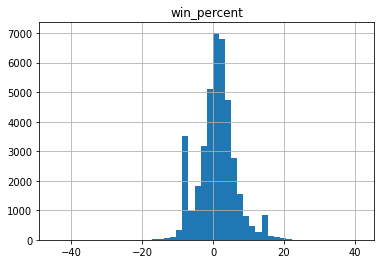

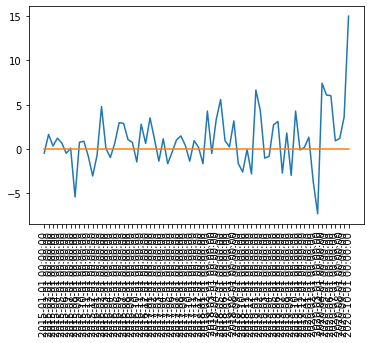

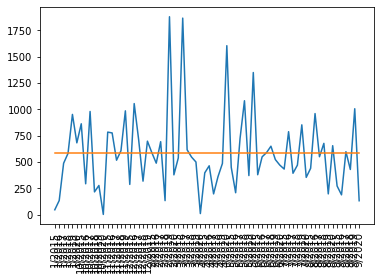

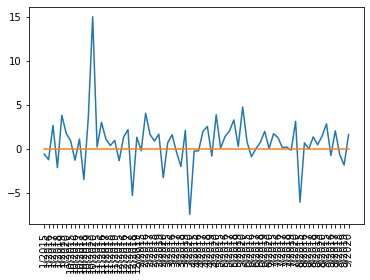

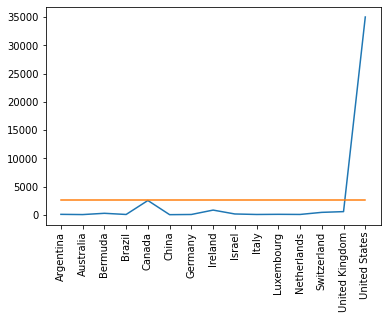

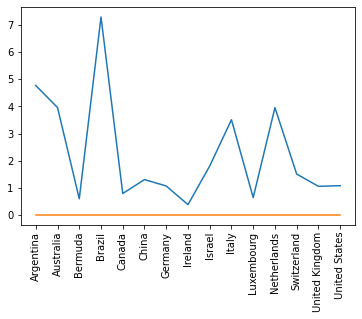

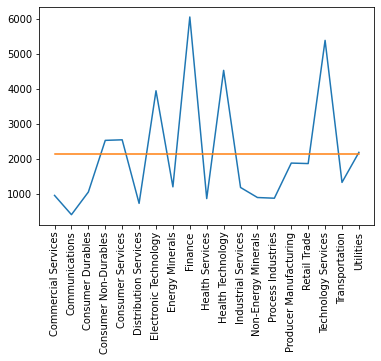

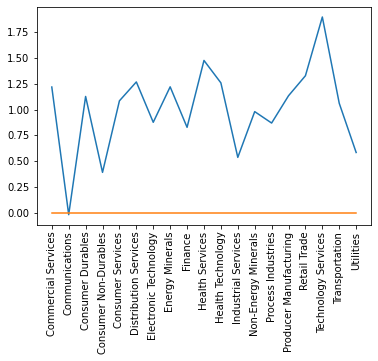

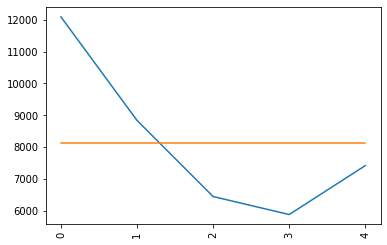

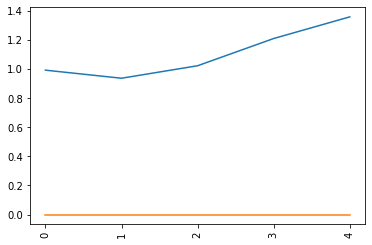

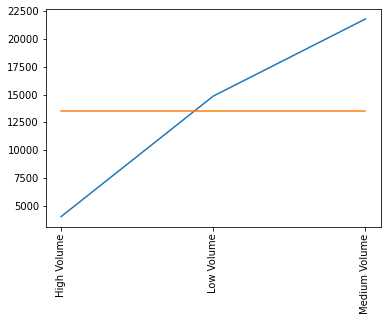

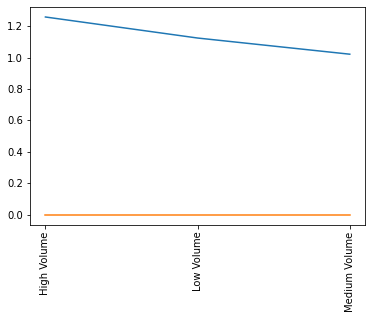

In [7]:
trades = analyse_results(data_with_earnings, print_figures=True, max_trades_by_day=2, min_invest_per_trade=0.04)

In [ ]:
print_cases(data_with_earnings, True, 0, 10)

### Clean data

In [8]:
import numpy as np
from datetime import datetime

# Avoid coronavirus period
cleaned_data = data_with_earnings[data_with_earnings["Date"] < datetime(2020, 1, 1)] 
# Avoid 2018 little crisis
cleaned_data = cleaned_data[(cleaned_data["Date"] < datetime(2018, 11, 1)) | (cleaned_data["Date"] > datetime(2018, 12, 31))]

## Simulate top tickers

/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


+-----------------------+-------+
|          KPI          | value |
+-----------------------+-------+
|   Enter cases number  | 20962 |
|  Cases number per day |  16.2 |
| Average winning cases |  62.7 |
|      Average win      |  0.88 |
|     Win for 20 K€     | 47750 |
|       Trade fees      |  6938 |
|      Trade number     |  3469 |
|      Total margin     | 204.1 |
+-----------------------+-------+


/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


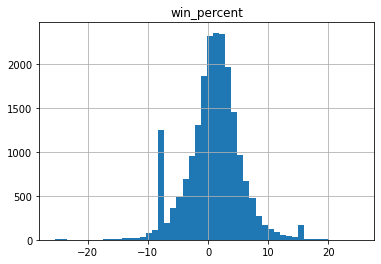

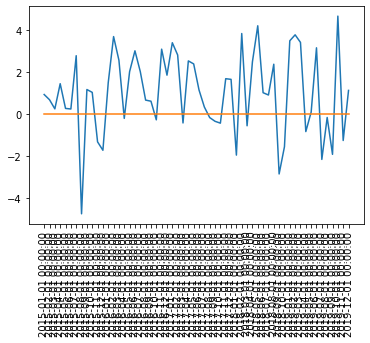

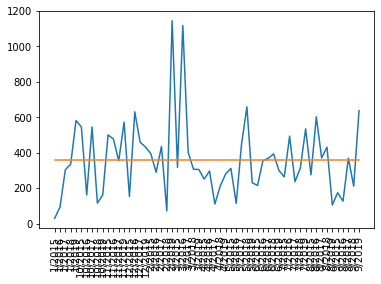

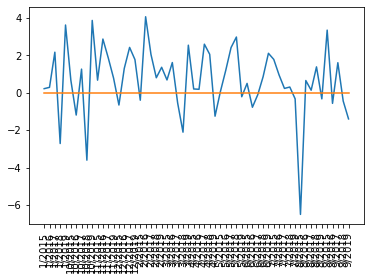

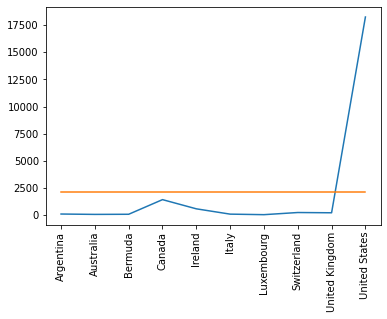

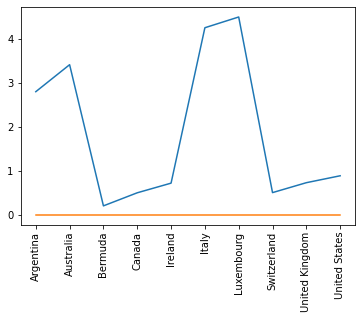

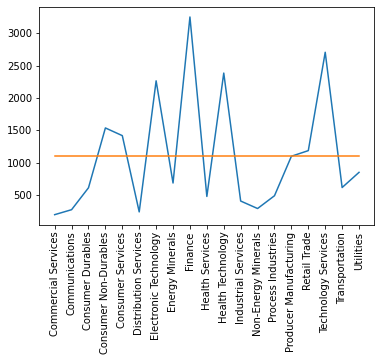

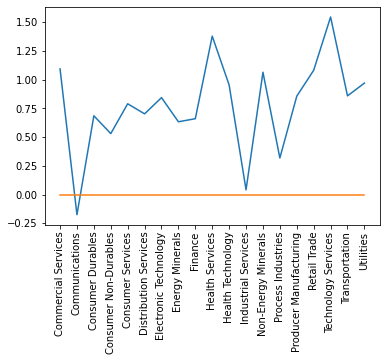

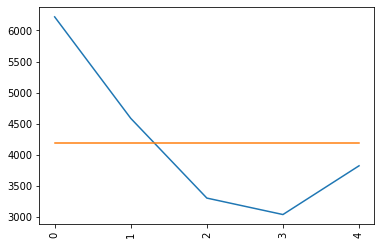

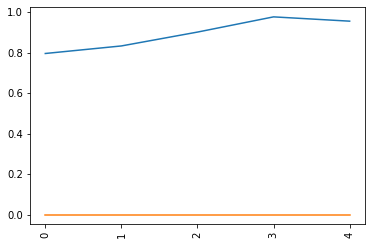

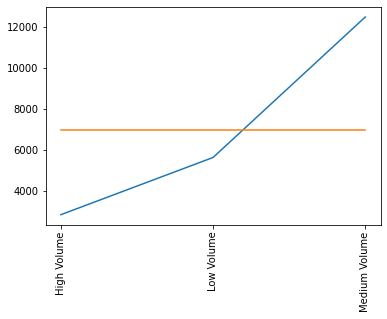

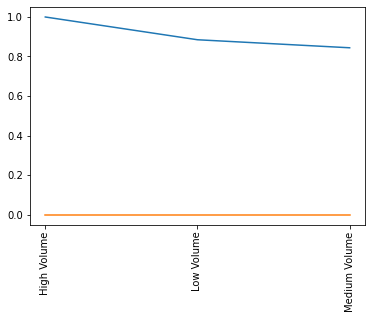

In [9]:
# Take 100 top tickers
top_tickers = get_top_tickers(0, 300)
top_companies_trades = cleaned_data[cleaned_data["Ticker"].isin(top_tickers)]
analyse_results(top_companies_trades, True, total_amount=20000, max_trades_by_day=4, min_invest_per_trade=0.04)


In [ ]:
print_results_by_column(df)

In [ ]:
ticker = ""
ticker_trades = top_companies_trades[top_companies_trades["Ticker"] == ticker]
ticker_trades[["Ticker", "Date", "win_percent", "exit_date", "exit_reason"]]
print_results_by_column(top_companies_trades)

## LABORATORY

In [ ]:
# Try losing days

df = top_companies_trades.copy(deep=True)#[cleaned_data["Close"] < 1 * cleaned_data["Open"]]
df = df[df["Close"] > df["Open"]]
df = df[df["long_ema_evolution"]/df["Close"] > 0.002]
df = df[df["week_previous_entries"] > 0]
df = df[df["short_ema_evolution"] > 0.1]
df = df[df["earnings_surprise"] < 20]
analyse_results(df, False, total_amount=20000, max_trades_by_day=10, min_invest_per_trade=0.05)

In [ ]:
print_cases(df, False, 10, 20)

In [ ]:
df.groupby

## END LABORATORY

## Today results

In [ ]:
import pandas as pd

from tadawol.strategies import recovery
from tadawol.strategies import macd
from tadawol.history import get_top_tickers
from tadawol.earnings import get_earnings_data_on_all_dates

strategy = macd.MACD()

tickers = get_top_tickers(0, 100)
macd_today_trades, macd_today_exits = strategy.get_today_trades_and_exits(tickers)


earnings_by_date = get_earnings_data_on_all_dates(macd_today_trades)
macd_today_trades = pd.merge(macd_today_trades, earnings_by_date, on=["Ticker", "Date"])
#macd_today_trades = macd_today_trades[macd_today_trades["days_to_next_result"] > 20]
#macd_today_trades = macd_today_trades[macd_today_trades["days_since_last_result"] > 0]
macd_today_trades = macd_today_trades[macd_today_trades["week_previous_entries"] >= 1]



In [ ]:
macd_today_trades["exit"].max()
#macd_today_exits.sort_values(by=["Date"], ascending=False).head()

In [ ]:
macd_today_trades["Date"].max()

In [ ]:
columns = [
        "Date", "Ticker", "company_short_name", "Close", "week_previous_entries",
        "earnings_surprise", "days_to_next_result", "exit_reason"]

tr = today_trades[columns]

In [ ]:

from tadawol.strategies import earnings
from tadawol.strategies import macd
from tadawol.history import get_top_tickers
from tadawol.earnings import get_earnings_data_on_all_dates

strategy = macd.MACD()

tickers = get_top_tickers(0, 300)
earnings_today_trades_1, earnings_today_exits_1 = strategy.get_today_trades_and_exits(tickers)


In [ ]:
earnings_today_trades = earnings_today_trades_1[earnings_today_trades_1["week_previous_entries"] >= 1]

In [ ]:
earnings_today_trades_1

In [ ]:
columns = ["Date", "Ticker", "exit", "exit_data", "entry", "Close"]

for i in range(1, 16):
    columns.append("Close_{}".format(i))

earnings_today_trades_1[earnings_today_trades_1["week_previous_entries"] >= 1].sort_values(by="Date", ascending=False).head(50)[columns]

In [ ]:
from datetime import datetime

earnings_today_trades_1[earnings_today_trades_1["exit"] == datetime(2020, 9, 30)].head()

In [ ]:
from tadawol import earnings
earnings_df = earnings.get_earnings_df()


In [ ]:
earnings_df = earnings_df[earnings_df["ticker"] == "PGR"]
earnings_df.sort_values(by=["Date"], ascending=False, inplace=True)
earnings_df.head()

In [ ]:
from tadawol import history
import pandas as pd

history = df = pd.read_csv(history.TICKERS_LIST_PATH)

In [ ]:
history[history["Ticker"] == "PGR"]